# Plotting a pourbaix diagram using the new Materials Project API

*If you use this infrastructure, please consider citing the following work:*

[K. A. Persson, B. Waldwick, P. Lazic and G. Ceder, Phys. Rev. B, 2012, 85, 235438.](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.85.235438)

[A. K. Singh, L. Zhou, A. Shinde, S. K. Suram, J. H. Montoya, D. Winston, J. M. Gregoire and K. A. Persson, Chem. Mater., 2017, DOI: acs.chemmater.7b03980.](http://pubs.acs.org/doi/10.1021/acs.chemmater.7b03980)

**Notebook Author:** Joseph Montoya, Ryan Kingsbury

**Last Update** 2023-03-10

For more information, please refer to the following documentation pages

- [Aqueous Stabiliity (Pourbaix Diagram)](https://docs.materialsproject.org/methodology/materials-methodology/aqueous-stability-pourbaix)
- [Pourbaix App Tutorial](https://docs.materialsproject.org/apps/analysis-apps/pourbaix-diagram/tutorial)
- [New Materials Project API reference](https://next-gen.materialsproject.org/api)

----------

The Materials Project REST interface includes functionality to construct pourbaix diagrams from computed entries.  Note that the Pourbaix infrastructure is still undergoing revision, but now includes a simplified interface that enables MP and pymatgen users to fetch entries that have been processed according to the [Materials Project Aqueous Compatibility scheme](https://docs.materialsproject.org/methodology/materials-methodology/aqueous-stability-pourbaix).  Thus, users can reproduce web Pourbaix diagrams in two or three steps in pymatgen.

In [ ]:
# Uncomment the subsequent lines in this cell to install dependencies for Google Colab.
# !pip install pymatgen==2022.7.19
# !pip install mp-api

**NOTE** - make sure to paste your **new** API key below.

In [ ]:
MP_API_KEY = "<your-legacy-API-key-here>"

In [ ]:
# Import necessary tools from pymatgen
from pymatgen.analysis.pourbaix_diagram import PourbaixDiagram, PourbaixPlotter
from mp_api.client import MPRester

%matplotlib inline

# Initialize the MP Rester
mpr = MPRester(MP_API_KEY)

## Automatic Pourbaix Diagram generation with `get_pourbaix_entries`

To retrieve entries necessary to construct a Pourbaix Diagram use `MPRester.get_pourbaix_entries(LIST_OF_ELEMENTS)` with a list of elements comprising your chemical system.  It is not necessary to include 'O' and 'H' in your list, as they are added automatically.  This function also contains all of necessary preprocessing to ensure the PourbaixEntries are compatible with the pymatgen `PourbaixDiagram` constructor.

In [ ]:
# Get all pourbaix entries corresponding to the Cu-O-H chemical system.
entries = mpr.get_pourbaix_entries(["Cu"])

Retrieving ThermoDoc documents:   0%|          | 0/112 [00:00<?, ?it/s]

Pourbaix diagrams can be constructed using `PourbaixDiagram(RETRIEVED_ENTRIES)` as below.  Note that a `comp_dict` keyword argument may also be supplied to the `PourbaixDiagram` constructor if a fixed composition for a multi-element pourbaix diagram is desired.

In [ ]:
# Construct the PourbaixDiagram object
pbx = PourbaixDiagram(entries)

The `PourbaixDiagram` includes a number of useful functions for determining stable species and stability of entries relative to a given pourbaix facet (i.e. as a function of pH and V).

In [ ]:
# Get an entry stability as a function of pH and V
entry = [e for e in entries if e.entry_id == "mp-1692-GGA"][0]
print(
    "CuO's potential energy per atom relative to the most",
    "stable decomposition product is {:0.2f} eV/atom".format(
        pbx.get_decomposition_energy(entry, pH=7, V=-0.2)
    ),
)

CuO's potential energy per atom relative to the most stable decomposition product is 0.23 eV/atom


This suggests that CuO, for example, has a large driving force for decomposition at neutral pH and mildly reducing conditions.

To see this in more detail, we can plot the pourbaix diagram.  The `PourbaixPlotter` object is also initialized using an instance of the `PourbaixDiagram` object.

In [ ]:
plotter = PourbaixPlotter(pbx)

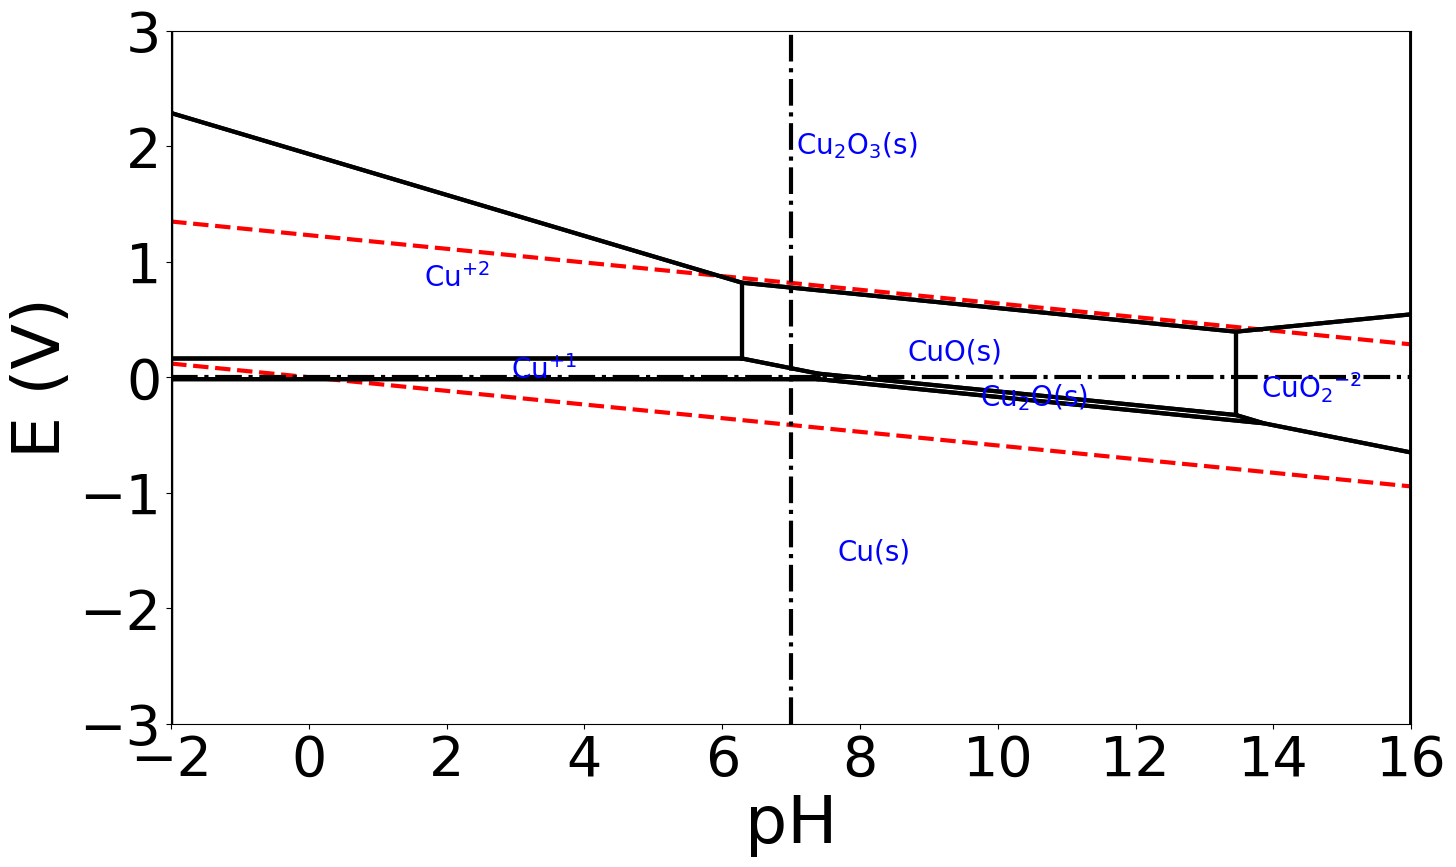

In [ ]:
plotter.get_pourbaix_plot().show()

You can customize the appearance of the plot using keyword arguments

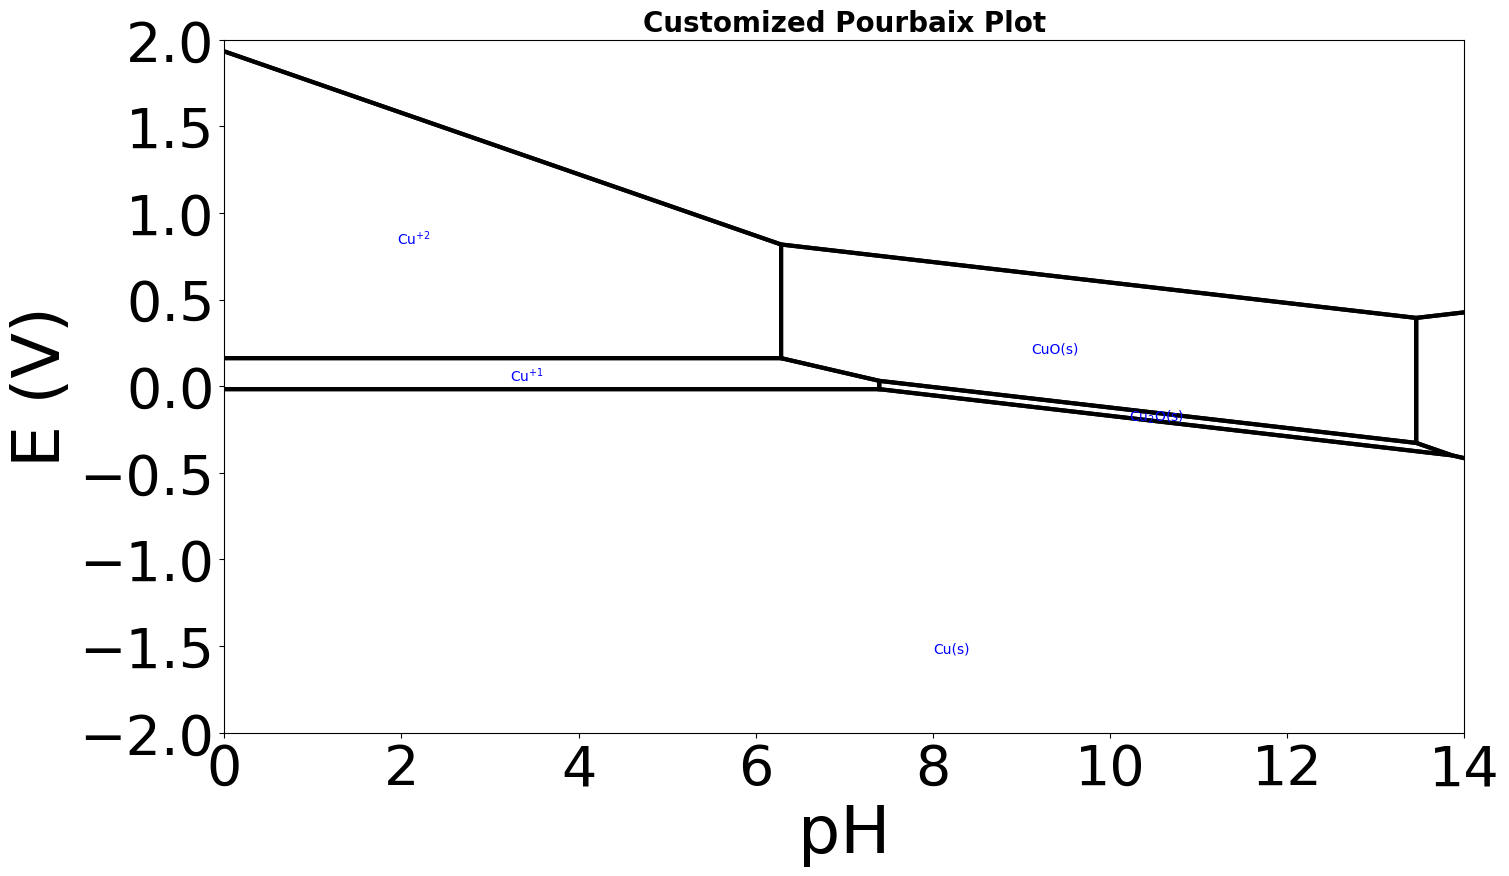

In [ ]:
plotter.get_pourbaix_plot(limits=[[0,14], [-2,2]], # pH and E limits
                          title="Customized Pourbaix Plot",
                            label_domains=True, # set True to label phases
                            label_fontsize=10, # font size for the phase labels
                            show_neutral_axes=False, # show or hide axes at pH=0, E=0
                            show_water_lines=False, # show or hide lines for water stability
).show()

The PourbaixPlotter object can also plot the relative stability of an entry across the pourbaix diagram.  To do this, use the `PourbaixPlotter.plot_entry_stability` method.

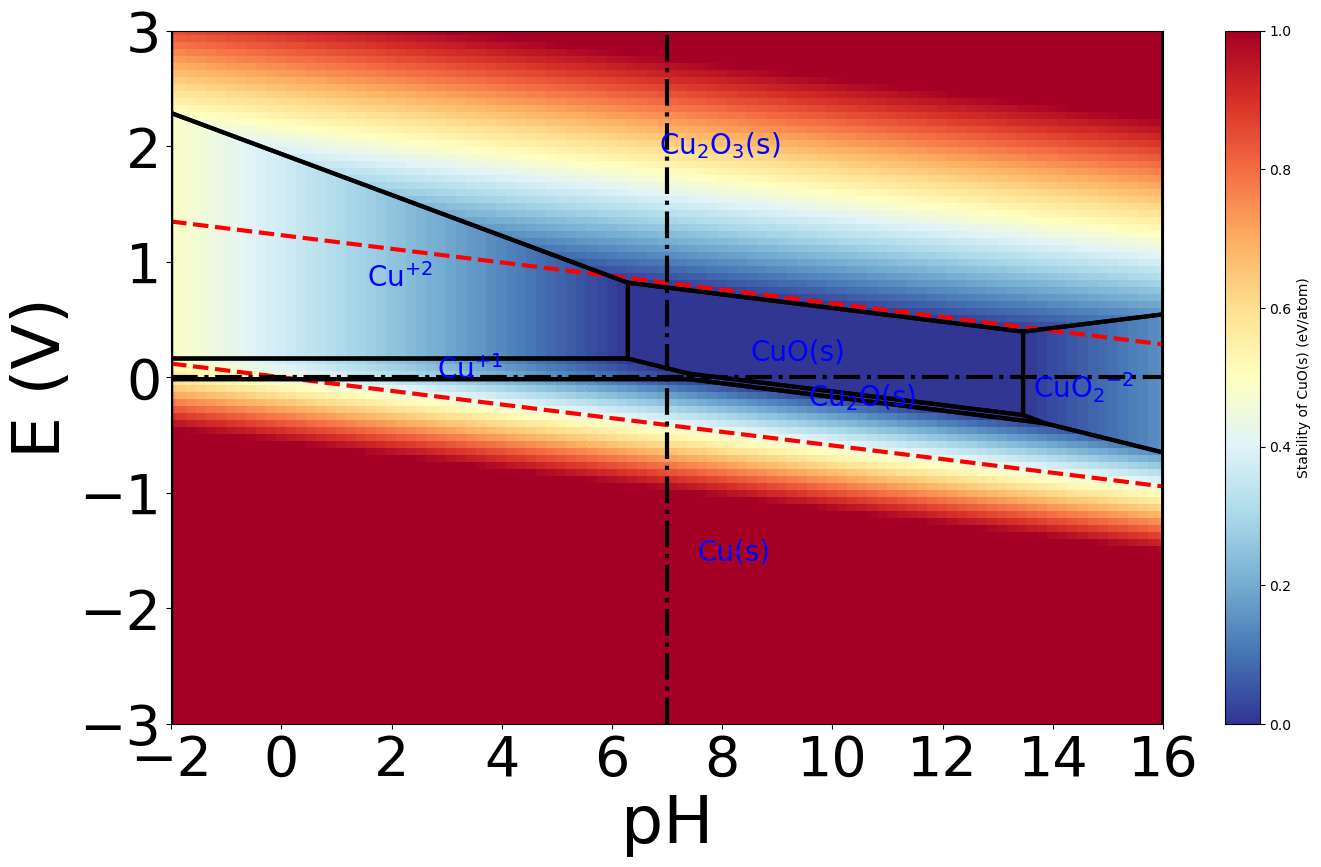

In [ ]:
plt = plotter.plot_entry_stability(entry)
plt.show()

# Plotting k-nary systems

Pymatgen also supports binary/ternary pourbaix diagrams with fixed compositions of the non-H or O elements.  This is achieved by finding all possible combinations of entries that fulfill the composition constraint and treating them as individual entries in pourbaix space.  Note that you can supply a composition dictionary to further tune the pourbaix diagram.

In [ ]:
# Get all pourbaix entries corresponding to the Bi-V-O-H chemical system.
entries = mpr.get_pourbaix_entries(["Bi", "V"])
# Construct the PourbaixDiagram object
pbx = PourbaixDiagram(
    entries,
    comp_dict={"Bi": 0.5, "V": 0.5},
    conc_dict={"Bi": 1e-8, "V": 1e-8},
    filter_solids=True,
)

Retrieving ThermoDoc documents:   0%|          | 0/434 [00:00<?, ?it/s]

Note that the `filter_solids` keyword argument in the `PourbaixDiagram` instantiation above tells the constructor whether to filter solids by phase stability on the compositional phase diagram for solids. The filtering process significantly reduces the time it takes to generate all of the combined entries for a binary or ternary pourbaix diagram though, so it may be prudent to use in those cases. Pourbaix Diagrams generated with and without this argument may look significantly different in the OER and HER regions, since highly oxidized materials (e. g. Bi$_2$O$_5$) or highly reduced materials (e. g. most hydrides) may not be stable on the compositional phase diagram. 

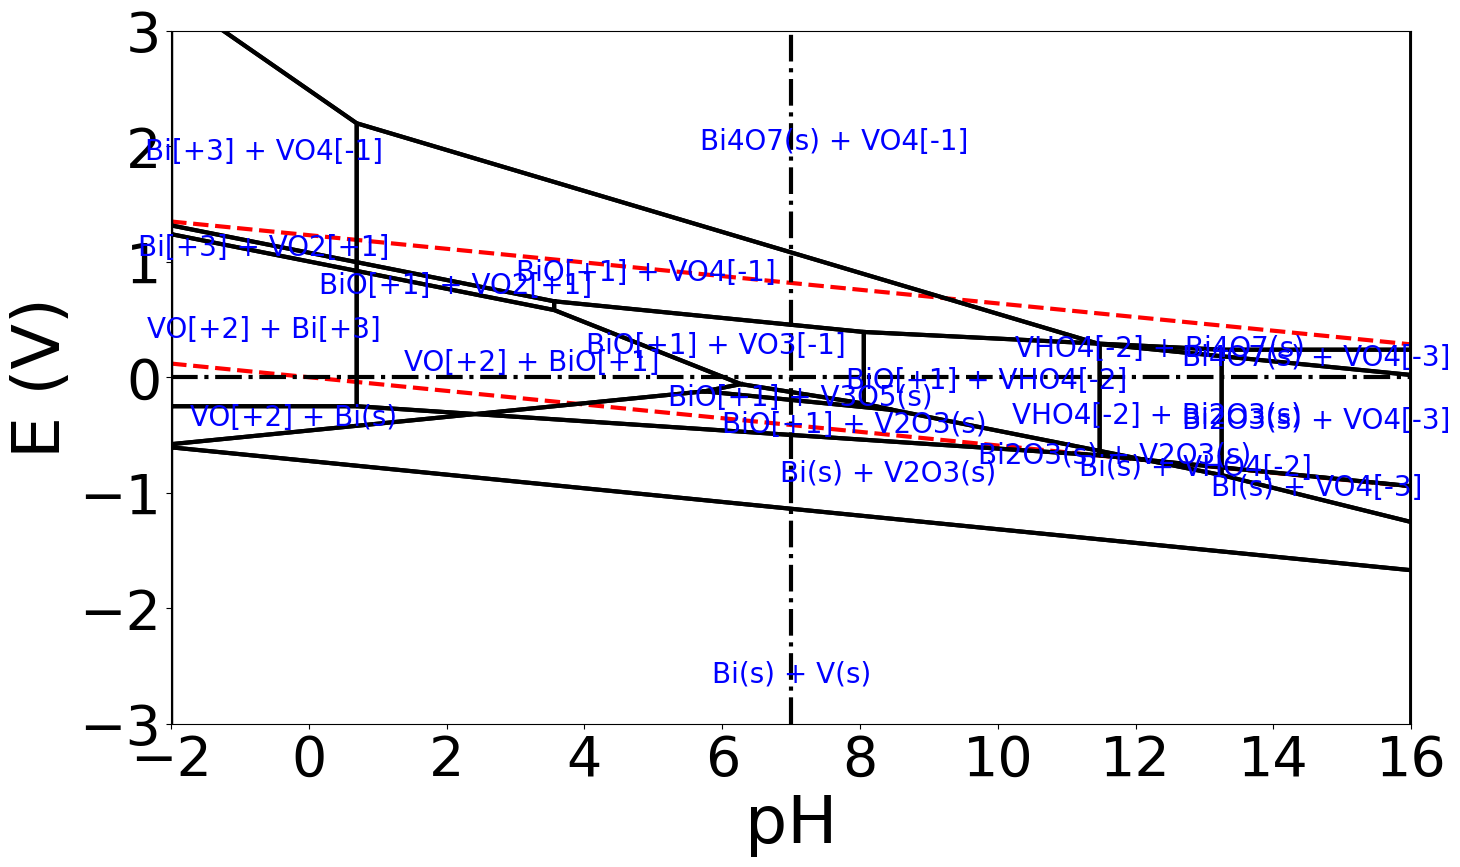

In [ ]:
# Construct the pourbaix analyzer
plotter = PourbaixPlotter(pbx)
plt = plotter.get_pourbaix_plot()
plt.show()

Getting the heatmaps for a solid entry in these cases is a bit more involved, because many of the regions of the pourbaix diagram include multiphase entries.  Here's an example for this case.

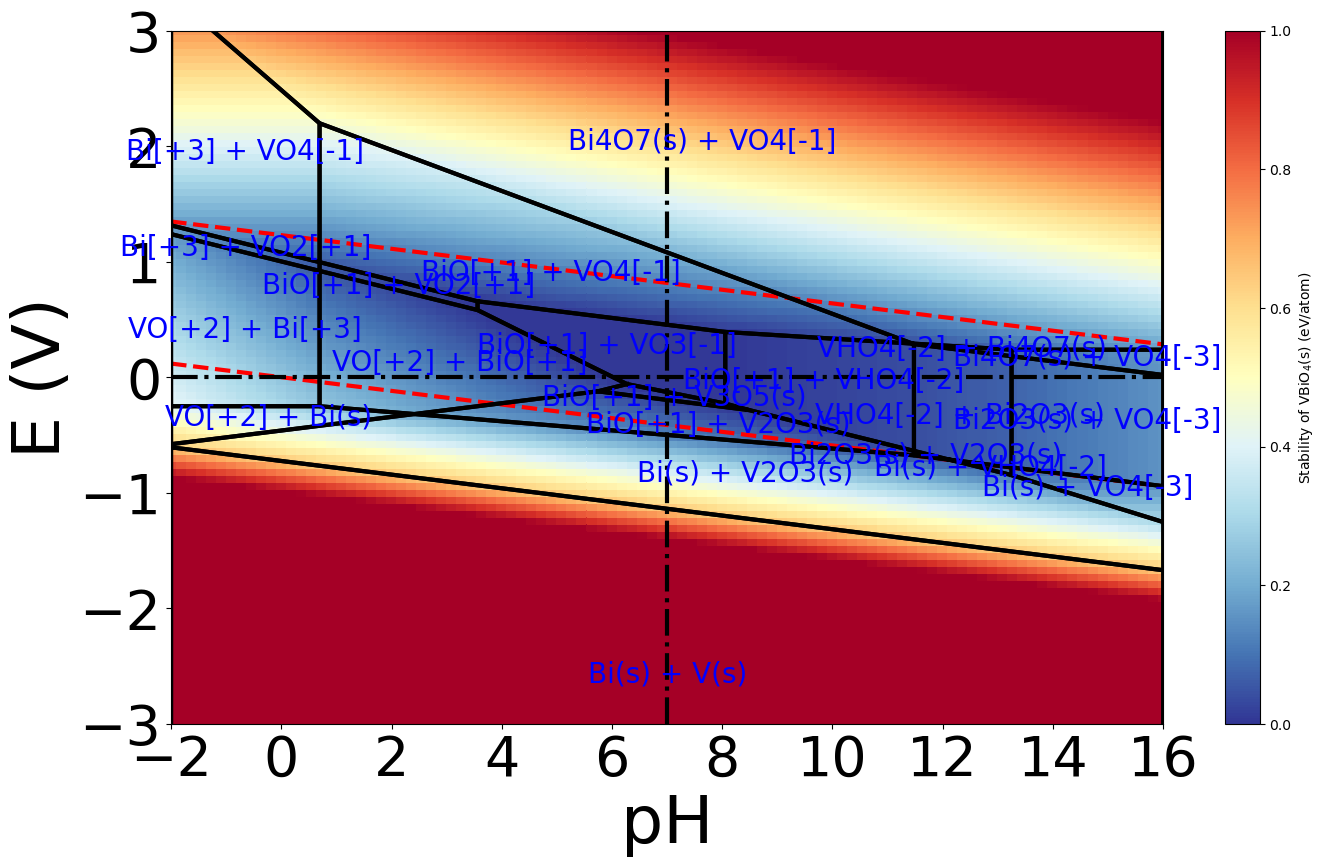

In [ ]:
bivo4_entry = [entry for entry in entries if entry.entry_id == "mp-545850-GGA+U"][0]
plt = plotter.plot_entry_stability(bivo4_entry)

If a compound is provided that doesn't meet the constraints of the composition (in this case, equal parts Bi and V), you will get a `ValueError`

ValueError: Composition of stability entry does not match Pourbaix Diagram

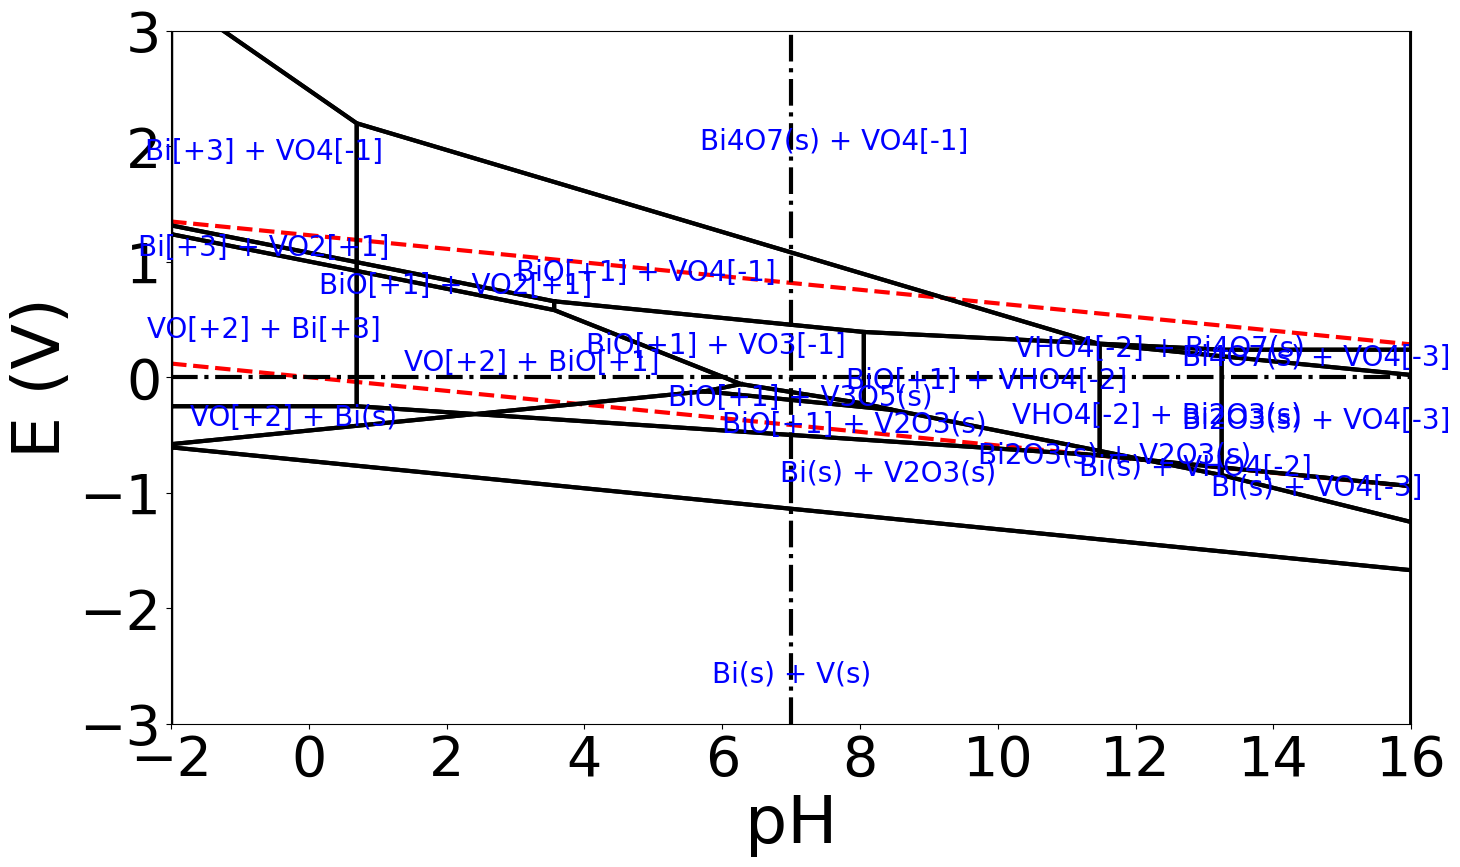

In [ ]:
bio2_entry = [entry for entry in entries if entry.entry_id == "mp-557993-GGA"][0]
plt = plotter.plot_entry_stability(bio2_entry)

## Building a Pourbaix Diagram manually

This section describes how to build a `PourbaixDiagram`. This is useful if you want to add solid phases that are not in the Materials Project database, if you want to remove some phases, or if you want to supply customized data for aqueous species.

First, download all the relevant entries for **solid phases** in the chemical system of interest. Note that **you must always include O and H in the chemical system** here

In [ ]:
with MPRester(MP_API_KEY) as m:
    solid_entries = m.get_entries_in_chemsys("Bi-V-O-H")

Retrieving ThermoDoc documents:   0%|          | 0/434 [00:00<?, ?it/s]

Next, process the solid entries using `MaterialsProjectAqueousCompatibility`, which makes adjustments to the energies to account for room temperature entropic effects and to guarantee that the formation energy of `H2O` is accurate.

In [ ]:
from pymatgen.entries.compatibility import MaterialsProjectAqueousCompatibility

aqcompat=MaterialsProjectAqueousCompatibility()
solid_entries = aqcompat.process_entries(solid_entries)

Failed to guess oxidation states for Entry mp-642644-GGA (V2H). Assigning anion correction to only the most electronegative atom.
Failed to guess oxidation states for Entry mp-1017530-GGA (VH). Assigning anion correction to only the most electronegative atom.
Failed to guess oxidation states for Entry mp-1002114-GGA (VH). Assigning anion correction to only the most electronegative atom.
Failed to guess oxidation states for Entry mp-642659-GGA (V2H). Assigning anion correction to only the most electronegative atom.
Failed to guess oxidation states for Entry mp-714972-GGA+U (V8O). Assigning anion correction to only the most electronegative atom.
Failed to guess oxidation states for Entry mp-796383-GGA+U (V3O8). Assigning anion correction to only the most electronegative atom.
Failed to guess oxidation states for Entry mp-826024-GGA+U (VO3). Assigning anion correction to only the most electronegative atom.
Failed to guess oxidation states for Entry mp-1100921-GGA+U (V7O3). Assigning anion

The `ComputedEntry` we processed above contain electronic energies from DFT calculations. But to construct `PourbaixEntry`, we need their _free energies of formation_. In addition, we will need to exclude entries in the `O`, `H`, and `O-H` chemical system when we build the diagram. To determine the free energies, we use the `get_form_energy` of the compositional `PhaseDiagram` for solids.

In [ ]:
from pymatgen.analysis.phase_diagram import PhaseDiagram
from pymatgen.analysis.pourbaix_diagram import PourbaixEntry
from pymatgen.entries.computed_entries import ComputedEntry

free_energy_entries = []

pd = PhaseDiagram(solid_entries)
for v in pd.stable_entries:
    if v.composition.chemical_system in ["O", "H", "H-O"]:
        continue
    # create a new ComputedEntry with the formation energy. Copy all other parameters
    # from the original ComputedEntry.
    free_energy_entries.append(ComputedEntry(v.composition, pd.get_form_energy(v),
                                      parameters=v.parameters))

Now, use the `get_ion_reference_data_for_chemsys` method to download reference data for all relevant aqueous species.

In [ ]:
with MPRester(MP_API_KEY) as m:
    ion_data = m.get_ion_reference_data_for_chemsys(["Bi","V"])

The next step is to construct ion entries, which reference the free energies of aqueous species to the formation energies on the solid phase diagram

In [ ]:
from pymatgen.analysis.phase_diagram import PhaseDiagram

with MPRester(MP_API_KEY) as m:
    ion_entries = m.get_ion_entries(pd, ion_data)

Now, we create `PourbaixEntry` from both the solid `ComputedEntry` and the aqueous `IonEntry` objects. The resulting list of `PourbaixEntry` is equivalent to what is returned by `get_pourbaix_entries` in the first section

In [ ]:
from pymatgen.analysis.pourbaix_diagram import PourbaixEntry

pbx_entries = [PourbaixEntry(e) for e in free_energy_entries]
pbx_entries.extend([PourbaixEntry(e) for e in ion_entries])

And finally, we create the `PourbaixDiagram` from the list of `PourbaixEntry` we have generated.

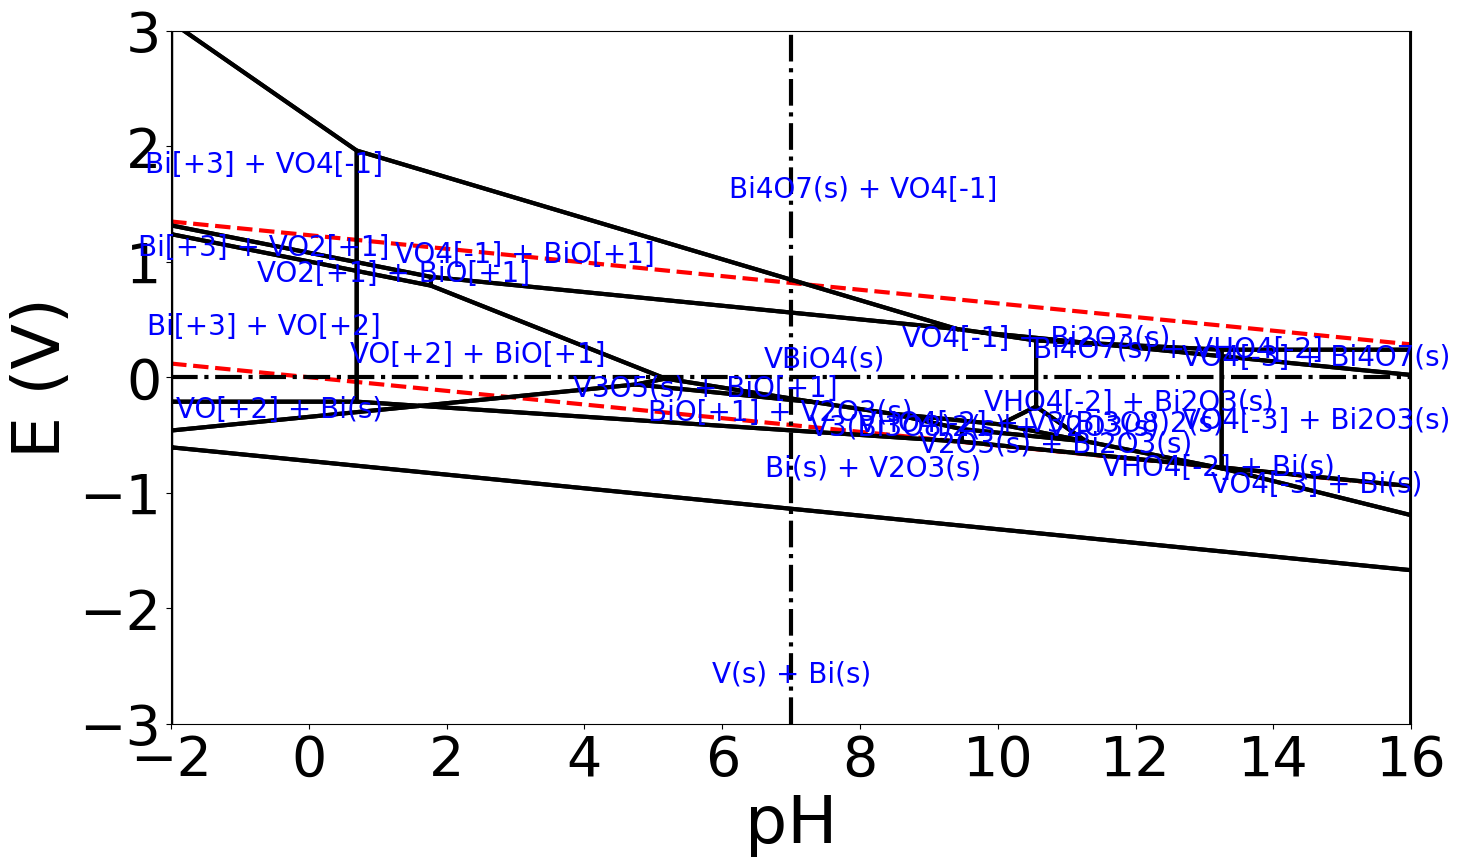

In [ ]:
pbx = PourbaixDiagram(pbx_entries)
pbplotter = PourbaixPlotter(pbx).get_pourbaix_plot().show()